<a href="https://colab.research.google.com/github/zddang/InstantMesh/blob/main/InstantMesh_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content
!GIT_LFS_SKIP_SMUDGE=1 git clone -b dev https://github.com/camenduru/InstantMesh
%cd /content/InstantMesh

!pip install pytorch-lightning==2.1.2 gradio==3.50.2 einops omegaconf torchmetrics webdataset accelerate tensorboard
!pip install PyMCubes trimesh rembg transformers diffusers==0.20.2 bitsandbytes imageio[ffmpeg] xatlas plyfile
!pip install git+https://github.com/NVlabs/nvdiffrast jax==0.4.19 jaxlib==0.4.19 ninja

/content/InstantMesh


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

The config attributes {'dropout': 0.0, 'reverse_transformer_layers_per_block': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
<ipython-input-4-0d71510a2fed>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't h

  0%|          | 0/75 [00:00<?, ?it/s]

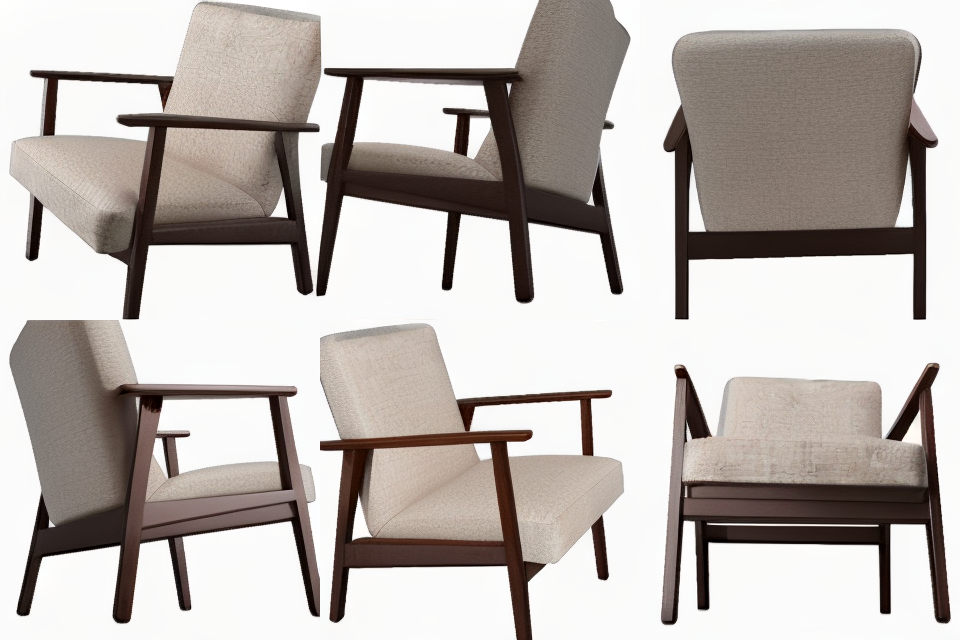

In [4]:
%cd /content/InstantMesh

import torch
model = None
torch.cuda.empty_cache()

import numpy as np
import rembg
from PIL import Image
from pytorch_lightning import seed_everything
from einops import rearrange
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler
from huggingface_hub import hf_hub_download
from src.utils.infer_util import remove_background, resize_foreground

pipeline = DiffusionPipeline.from_pretrained("sudo-ai/zero123plus-v1.2", custom_pipeline="zero123plus",torch_dtype=torch.float16,)
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config, timestep_spacing='trailing')
unet_ckpt_path = hf_hub_download(repo_id="TencentARC/InstantMesh", filename="diffusion_pytorch_model.bin", repo_type="model")
state_dict = torch.load(unet_ckpt_path, map_location='cpu')
pipeline.unet.load_state_dict(state_dict, strict=True)
device = torch.device('cuda')
pipeline = pipeline.to(device)
seed_everything(0)

def preprocess(input_image, do_remove_background):
    rembg_session = rembg.new_session() if do_remove_background else None
    if do_remove_background:
        input_image = remove_background(input_image, rembg_session)
        input_image = resize_foreground(input_image, 0.85)
    return input_image

def generate_mvs(input_image, sample_steps, sample_seed):
    seed_everything(sample_seed)
    generator = torch.Generator(device=device)
    z123_image = pipeline(
        input_image,
        num_inference_steps=sample_steps,
        generator=generator,
    ).images[0]
    show_image = np.asarray(z123_image, dtype=np.uint8)
    show_image = torch.from_numpy(show_image)     # (960, 640, 3)
    show_image = rearrange(show_image, '(n h) (m w) c -> (n m) h w c', n=3, m=2)
    show_image = rearrange(show_image, '(n m) h w c -> (n h) (m w) c', n=2, m=3)
    show_image = Image.fromarray(show_image.numpy())
    return z123_image, show_image

input_image_path = '/content/InstantMesh/examples/armchair128.jpg' #@param {type:"string"}
input_image = Image.open(input_image_path)
processed_image = preprocess(input_image, True)
processed_image
mv_images, mv_show_images = generate_mvs(processed_image, 75, 42)
mv_images.save('/content/InstantMesh/mv_images.png')
mv_show_images

In [5]:
%cd /content/InstantMesh

import torch
pipeline = None
torch.cuda.empty_cache()

import os
from torchvision.transforms import v2
from huggingface_hub import hf_hub_download
from omegaconf import OmegaConf
from PIL import Image
import numpy as np
from einops import rearrange, repeat
import tempfile
from tqdm import tqdm
import imageio

from src.utils.train_util import instantiate_from_config
from src.utils.camera_util import (FOV_to_intrinsics, get_zero123plus_input_cameras,get_circular_camera_poses,)
from src.utils.mesh_util import save_obj, save_obj_with_mtl

config_path = 'configs/instant-mesh-base.yaml'
config = OmegaConf.load(config_path)
config_name = os.path.basename(config_path).replace('.yaml', '')
model_config = config.model_config
infer_config = config.infer_config
model_ckpt_path = hf_hub_download(repo_id="TencentARC/InstantMesh", filename="instant_mesh_base.ckpt", repo_type="model")
model = instantiate_from_config(model_config)
state_dict = torch.load(model_ckpt_path, map_location='cpu')['state_dict']
state_dict = {k[14:]: v for k, v in state_dict.items() if k.startswith('lrm_generator.') and 'source_camera' not in k}
model.load_state_dict(state_dict, strict=True)
device = torch.device('cuda')
model = model.to(device)
IS_FLEXICUBES = True if config_name.startswith('instant-mesh') else False
if IS_FLEXICUBES:
    model.init_flexicubes_geometry(device, fovy=30.0)
model = model.eval()

def images_to_video(images, output_path, fps=30):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    frames = []
    for i in range(images.shape[0]):
        frame = (images[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8).clip(0, 255)
        assert frame.shape[0] == images.shape[2] and frame.shape[1] == images.shape[3], \
            f"Frame shape mismatch: {frame.shape} vs {images.shape}"
        assert frame.min() >= 0 and frame.max() <= 255, \
            f"Frame value out of range: {frame.min()} ~ {frame.max()}"
        frames.append(frame)
    imageio.mimwrite(output_path, np.stack(frames), fps=fps, codec='h264')

def get_render_cameras(batch_size=1, M=120, radius=2.5, elevation=10.0, is_flexicubes=False):
    c2ws = get_circular_camera_poses(M=M, radius=radius, elevation=elevation)
    if is_flexicubes:
        cameras = torch.linalg.inv(c2ws)
        cameras = cameras.unsqueeze(0).repeat(batch_size, 1, 1, 1)
    else:
        extrinsics = c2ws.flatten(-2)
        intrinsics = FOV_to_intrinsics(30.0).unsqueeze(0).repeat(M, 1, 1).float().flatten(-2)
        cameras = torch.cat([extrinsics, intrinsics], dim=-1)
        cameras = cameras.unsqueeze(0).repeat(batch_size, 1, 1)
    return cameras

def make_mesh(mesh_fpath, planes):
    mesh_basename = os.path.basename(mesh_fpath).split('.')[0]
    mesh_dirname = os.path.dirname(mesh_fpath)
    mesh_vis_fpath = os.path.join(mesh_dirname, f"{mesh_basename}.glb")
    with torch.no_grad():
        mesh_out = model.extract_mesh(planes, use_texture_map=True, **infer_config,)
        vertices, faces, uvs, mesh_tex_idx, tex_map = mesh_out
        # vertices = vertices[:, [1, 2, 0]]
        # vertices[:, -1] *= -1
        # faces = faces[:, [2, 1, 0]]
        save_obj_with_mtl(
            vertices.data.cpu().numpy(),
            uvs.data.cpu().numpy(),
            faces.data.cpu().numpy(),
            mesh_tex_idx.data.cpu().numpy(),
            tex_map.permute(1, 2, 0).data.cpu().numpy(),
            mesh_fpath,
        )
        print(f"Mesh with texmap saved to {mesh_fpath}")
        # vertices, faces, vertex_colors = mesh_out
        # vertices = vertices[:, [1, 2, 0]]
        # vertices[:, -1] *= -1
        # faces = faces[:, [2, 1, 0]]
        # save_obj(vertices, faces, vertex_colors, mesh_fpath)
        # print(f"Mesh saved to {mesh_fpath}")
    return mesh_fpath

def make3d(images):
    images = np.asarray(images, dtype=np.float32) / 255.0
    images = torch.from_numpy(images).permute(2, 0, 1).contiguous().float()     # (3, 960, 640)
    images = rearrange(images, 'c (n h) (m w) -> (n m) c h w', n=3, m=2)        # (6, 3, 320, 320)
    input_cameras = get_zero123plus_input_cameras(batch_size=1, radius=4.0).to(device)
    render_cameras = get_render_cameras(
        batch_size=1, radius=4.5, elevation=20.0, is_flexicubes=IS_FLEXICUBES).to(device)
    images = images.unsqueeze(0).to(device)
    images = v2.functional.resize(images, (320, 320), interpolation=3, antialias=True).clamp(0, 1)
    directory = '/content/tmp'
    if not os.path.exists(directory):
        os.makedirs(directory)
    tempfile.tempdir = directory
    mesh_fpath = tempfile.NamedTemporaryFile(suffix=f".obj", delete=False).name
    print(mesh_fpath)
    mesh_basename = os.path.basename(mesh_fpath).split('.')[0]
    mesh_dirname = os.path.dirname(mesh_fpath)
    video_fpath = os.path.join(mesh_dirname, f"{mesh_basename}.mp4")
    with torch.no_grad():
        planes = model.forward_planes(images, input_cameras)
        chunk_size = 20 if IS_FLEXICUBES else 1
        render_size = 384
        frames = []
        for i in tqdm(range(0, render_cameras.shape[1], chunk_size)):
            if IS_FLEXICUBES:
                frame = model.forward_geometry(planes, render_cameras[:, i:i+chunk_size], render_size=render_size,)['img']
            else:
                frame = model.synthesizer(planes, cameras=render_cameras[:, i:i+chunk_size],render_size=render_size,)['images_rgb']
            frames.append(frame)
        frames = torch.cat(frames, dim=1)
        images_to_video(frames[0], video_fpath, fps=30,)
        print(f"Video saved to {video_fpath}")
    mesh_fpath = make_mesh(mesh_fpath, planes)
    return video_fpath, mesh_fpath

mv_images = Image.open('/content/InstantMesh/mv_images.png')
output_video, output_model_obj = make3d(mv_images)
!cp -f {output_video} /content/InstantMesh/output_video.mp4
!cp -f {output_model_obj} /content/InstantMesh/output_model.obj
from IPython.display import Video
Video(output_video, embed=True)

/content/InstantMesh


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['encoder.layer.0.adaLN_modulation.1.bias', 'encoder.layer.0.adaLN_modulation.1.weight', 'encoder.layer.1.adaLN_modulation.1.bias', 'encoder.layer.1.adaLN_modulation.1.weight', 'encoder.layer.10.adaLN_modulation.1.bias', 'encoder.layer.10.adaLN_modulation.1.weight', 'encoder.layer.11.adaLN_modulation.1.bias', 'encoder.layer.11.adaLN_modulation.1.weight', 'encoder.layer.2.adaLN_modulation.1.bias', 'encoder.layer.2.adaLN_modulation.1.weight', 'encoder.layer.3.adaLN_modulation.1.bias', 'encoder.layer.3.adaLN_modulation.1.weight', 'encoder.layer.4.adaLN_modulation.1.bias', 'encoder.layer.4.adaLN_modulation.1.weight', 'encoder.layer.5.adaLN_modulation.1.bias', 'encoder.layer.5.adaLN_modulation.1.weight', 'encoder.layer.6.adaLN_modulation.1.bias', 'encoder.layer.6.adaLN_modulation.1.weight', 'encoder.layer.7.adaLN_modulation.1.bias', 'encoder.layer.7.adaLN_modulation.1.w

/content/tmp/tmphaew4xrm.obj


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Video saved to /content/tmp/tmphaew4xrm.mp4
Mesh with texmap saved to /content/tmp/tmphaew4xrm.obj
